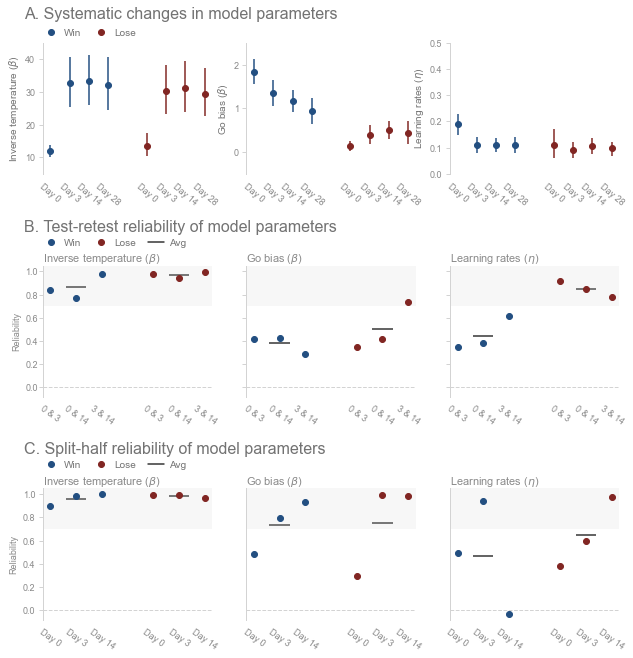

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import dirname
from pandas import read_csv, concat
sns.set_theme(style='ticks', context='notebook', font_scale=1.2, rc={'font.family': 'Arial'})
ROOT_DIR = dirname(dirname(dirname(os.path.realpath('__file__'))))
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define plot parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define variable ordering.
sessions = [1,2,3,4]

## Define axis styles.
labelcolor = '#737373'
tickcolor = '#8a8a8a'
axiscolor = '#d3d3d3'

## Define row 1 styling.
r1_xticks = np.concatenate([np.linspace(-0.3,0.3,4) + i for i in range(2)])
r1_xticklabels = np.tile(['Day 0', 'Day 3', 'Day 14', 'Day 28'], 2)
r1_ylims = [(5,45), (-0.5,2.5), (0.0,0.5)]
r1_yticks = [np.linspace(10,40,4), np.linspace(0,2,3), np.linspace(0.0,0.5,6)]
r1_ylabels = [r'Inverse temperature ($\beta$)', r'Go bias ($\beta$)', r'Learning rates ($\eta$)']
r1_palette = np.repeat(['#234f81', '#812623'], 4)

## Define row 2 styling.
r2_titles = [r'Inverse temperature ($\beta$)', r'Go bias ($\beta$)', r'Learning rates ($\eta$)']
r2_xticks = np.concatenate([np.linspace(-0.25,0.25,3) + i for i in range(2)])
r2_xticklabels = np.tile(['0 & 3', '0 & 14', '3 & 14'], 2)
r2_palette = np.repeat(['#234f81', '#812623'], 3)
r2_markers = np.tile(['o', 'o', 'o'], 2)

## Define row 3 styling.
r3_titles = [r'Inverse temperature ($\beta$)', r'Go bias ($\beta$)', r'Learning rates ($\eta$)']
r3_xticks = np.concatenate([np.linspace(-0.25,0.25,3) + i for i in range(2)])
r3_xticklabels = np.tile(['Day 0', 'Day 3', 'Day 14'], 2)
r3_palette = np.repeat(['#234f81', '#812623'], 3)
r3_markers = np.tile(['o', 'o', 'o'], 2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Initialize canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(9,9))

## Initialize gridspec.
gs = fig.add_gridspec(3, 3, left=0.09, right=0.98, top=0.94, bottom=0.05, 
                      hspace=0.70, wspace=0.20)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively load Stan summaries.
summary = concat([
    read_csv(
        os.path.join(ROOT_DIR, 'study01', 'stan_results', s, f'pgng_m7_summary.tsv'), 
        sep='\t', index_col=0
    ).assign(Session=s)
    for s in ['s1', 's2', 's3', 's4']
])

## Restrict to group-level parameters.
summary = summary.T.filter(regex='_mu').T.reset_index().set_index(['index','Session']).sort_index()

## Load reliability.
reliability = read_csv(os.path.join(ROOT_DIR, 'study01', 'stan_results', 'pgng_m7_reliability.csv'))
reliability = reliability.query('Group > 0').set_index(['Type','Param']).sort_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Row 1: Group-level parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Iteratively plot.
for i, (p1, p2, yticks, ylim, ylabel) in enumerate(zip(['b1','b3','a1'], ['b2','b4','a2'], r1_yticks, r1_ylims, r1_ylabels)):
    
    ## Initialize axis.
    ax = plt.subplot(gs[0,i])
    
    ## Iteratively plot.
    for j, (y, lb, ub, x, color) in enumerate(zip(summary.loc[[f'{p1}_mu',f'{p2}_mu'],'Mean'],
                                                  summary.loc[[f'{p1}_mu',f'{p2}_mu'],'2.5%'],
                                                  summary.loc[[f'{p1}_mu',f'{p2}_mu'],'97.5%'],
                                                  r1_xticks, r1_palette)):
        ax.errorbar(x=x, y=y, yerr=np.vstack([y-lb,ub-y]), fmt='o', color=color, elinewidth=1.5)

    ## Adjust x-axis.
    ax.set(xticks=r1_xticks, xticklabels=[])
    ax.set_xticklabels(r1_xticklabels, color=tickcolor, fontsize=9, rotation=-40)

    ## Adjust y-axis.
    ax.set(ylim=ylim, yticks=yticks)
    ax.set_yticklabels(ax.get_yticklabels(), color=tickcolor, fontsize=9)
    ax.set_ylabel(ylabel, color=labelcolor, fontsize=10)

    ## Adjust legend.
    if not i:
        ax.errorbar([], [], fmt='o', color='#234f81', label='Win')
        ax.errorbar([], [], fmt='o', color='#812623', label='Lose')
        ax.legend(loc=2, bbox_to_anchor=(0, 1.11), ncol=2, frameon=False, labelcolor=labelcolor, fontsize=10,
                  borderpad=0, borderaxespad=0, handletextpad=0.5, handlelength=1.6, columnspacing=1.2)
        
    ## Modify ax spines.
    # ax.yaxis.set_tick_params(pad=1)
    ax.spines['left'].set(linewidth=1, color=axiscolor)
    ax.tick_params(bottom=False, left=True, color=axiscolor, length=4, width=1)
    sns.despine(ax=ax, left=False, right=True, top=True, bottom=True)

    ## Add annotation.
    if not i: ax.annotate('A. Systematic changes in model parameters', (0,0), (-0.11,1.16), 
                          'axes fraction', ha='left', va='bottom', color=labelcolor, fontsize=16)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Row 2: Test-retest reliability.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively plot.
for i, (p1, p2, title) in enumerate(zip(['b1','b3','a1'], ['b2','b4','a2'], r3_titles)):
    
    ## Initialize axis.
    ax = plt.subplot(gs[1,i])

    ## Iteratively plot.
    for j, (y, lb, ub, x, fmt, color) in enumerate(zip(reliability.loc[('trt',[p1,p2]),'Mean'], 
                                                       reliability.loc[('trt',[p1,p2]),'2.5%'], 
                                                       reliability.loc[('trt',[p1,p2]),'97.5%'], 
                                                       r2_xticks, r2_markers, r2_palette)):        
        ax.errorbar(x=x, y=y, fmt=fmt, color=color, elinewidth=1.5)
        
    ## Plot averages.
    ax.hlines(reliability.loc[('trt',p1),'Mean'].mean(), -0.1, 0.1, color='0.2', lw=1.5,
              linestyle='-', zorder=-1)
    ax.hlines(reliability.loc[('trt',p2),'Mean'].mean(),  0.9, 1.1, color='0.2', lw=1.5,
              linestyle='-', zorder=-1)
    
    ## Add zero-line.
    ax.axhline(0, linewidth=1, color=axiscolor, linestyle='--')
    
    ## Add fill.
    x1, x2 = ax.get_xlim()
    ax.fill_betweenx([0.7,1.05], x1, x2, color=axiscolor, edgecolor='none', alpha=0.18)
    
    ## Adjust x-axis.
    ax.set(xlim=(x1, x2), xticks=r2_xticks, xticklabels=[])
    ax.set_xticklabels(r2_xticklabels, color=tickcolor, fontsize=9, rotation=-35)
    
    ## Adjust y-axis.
    ax.set(ylim=(-0.08,1.05), yticks=np.linspace(0.0,1.0,6), yticklabels=[])
    if not i:
        ax.set_yticklabels(ax.get_yticks().round(1), color=tickcolor, fontsize=9)
        ax.set_ylabel('Reliability', color=tickcolor, fontsize=9)
    
    ## Adjust title.
    ax.set_title(title, loc='left', color=tickcolor, fontsize=11, pad=4)

    ## Adjust legend.
    if not i:
        ax.errorbar([], [], fmt='o', color='#234f81', label='Win')
        ax.errorbar([], [], fmt='o', color='#812623', label='Lose')
        ax.errorbar([], [], fmt='-', color='0.2', label='Avg')
        ax.legend(loc=2, bbox_to_anchor=(0, 1.21), ncol=3, frameon=False, labelcolor=labelcolor, fontsize=10,
                  borderpad=0, borderaxespad=0, handletextpad=0.5, handlelength=1.6, columnspacing=1.2)
    
    ## Modify ax spines.
    ax.yaxis.set_tick_params(pad=1)
    ax.spines['left'].set(linewidth=1, color=axiscolor)
    ax.tick_params(bottom=False, left=True, color=axiscolor, length=4, width=1)
    sns.despine(ax=ax, left=False, right=True, top=True, bottom=True)
    
    ## Add annotation.
    if not i: ax.annotate('B. Test-retest reliability of model parameters', (0,0), (-0.11,1.24), 
                          'axes fraction', ha='left', va='bottom', color=labelcolor, fontsize=16)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Row 3: Split-half reliability.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively plot.
for i, (p1, p2, title) in enumerate(zip(['b1','b3','a1'], ['b2','b4','a2'], r2_titles)):
    
    ## Initialize axis.
    ax = plt.subplot(gs[2,i])

    ## Iteratively plot.
    for j, (y, lb, ub, x, fmt, color) in enumerate(zip(reliability.loc[('sh',[p1,p2]),'Mean'], 
                                                       reliability.loc[('sh',[p1,p2]),'2.5%'], 
                                                       reliability.loc[('sh',[p1,p2]),'97.5%'], 
                                                       r3_xticks, r3_markers, r3_palette)):        
        ax.errorbar(x=x, y=y, fmt=fmt, color=color, elinewidth=1.5)
    
    ## Plot averages.
    ax.hlines(reliability.loc[('sh',p1),'Mean'].mean(), -0.1, 0.1, color='0.2', lw=1.5,
              linestyle='-', zorder=-1)
    ax.hlines(reliability.loc[('sh',p2),'Mean'].mean(),  0.9, 1.1, color='0.2', lw=1.5,
              linestyle='-', zorder=-1)
    
    ## Add zero-line.
    ax.axhline(0, linewidth=1, color=axiscolor, linestyle='--')
    
    ## Add fill.
    x1, x2 = ax.get_xlim()
    ax.fill_betweenx([0.7,1.05], x1, x2, color=axiscolor, edgecolor='none', alpha=0.18)
    
    ## Adjust x-axis.
    ax.set(xlim=(x1, x2), xticks=r3_xticks, xticklabels=[])
    ax.set_xticklabels(r3_xticklabels, color=tickcolor, fontsize=9, rotation=-35)
    
    ## Adjust y-axis.
    ax.set(ylim=(-0.08,1.05), yticks=np.linspace(0.0,1.0,6), yticklabels=[])
    if not i:
        ax.set_yticklabels(ax.get_yticks().round(1), color=tickcolor, fontsize=9)
        ax.set_ylabel('Reliability', color=tickcolor, fontsize=9)
    
    ## Adjust title.
    ax.set_title(title, loc='left', color=tickcolor, fontsize=11, pad=4)

    ## Adjust legend.
    if not i:
        ax.errorbar([], [], fmt='o', color='#234f81', label='Win')
        ax.errorbar([], [], fmt='o', color='#812623', label='Lose')
        ax.errorbar([], [], fmt='-', color='0.2', label='Avg')
        ax.legend(loc=2, bbox_to_anchor=(0, 1.21), ncol=3, frameon=False, labelcolor=labelcolor, fontsize=10,
                  borderpad=0, borderaxespad=0, handletextpad=0.5, handlelength=1.6, columnspacing=1.2)
        
    ## Modify ax spines.
    ax.spines['left'].set(linewidth=1, color=axiscolor)
    sns.despine(ax=ax, left=False, right=True, top=True, bottom=True)
    ax.tick_params(bottom=False, left=False, color=axiscolor, length=4, width=1)
    if not i: ax.tick_params(left=True, color=axiscolor, length=4, width=1)
    
    ## Add annotation.
    if not i: ax.annotate('C. Split-half reliability of model parameters', (0,0), (-0.11,1.24), 
                          'axes fraction', ha='left', va='bottom', color=labelcolor, fontsize=16)
    
## Save figure.
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'fig03.svg'), dpi=100)